# Term project(2): Spherical Jeans Equation
**023426910029  胡旭凡   2023.12.25**


## 1. 数据处理

In [13]:
import numpy as np
import astropy as ap
from astropy.io import fits
from astropy.stats import bootstrap
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

G=4.3e-6
rd=np.array([6,9,12,15,20,25,30,35,40,50,65,100])

In [2]:
hdu=fits.open('lamost_kg_dr5_smoothhalo.fits')
hdu.info()

Filename: lamost_kg_dr5_smoothhalo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (368153,)   uint8   
  1  Joined        1 BinTableHDU    152   9215R x 67C   [J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E, E, E]   


In [3]:
hdu[1].data[0][1]

-9.762576

In [4]:
l=[]
for i in range(9215):
    l.append([hdu[1].data[i][1],hdu[1].data[i][3],hdu[1].data[i][5],hdu[1].data[i][29],hdu[1].data[i][30],
              hdu[1].data[i][31],hdu[1].data[i][32],hdu[1].data[i][33],hdu[1].data[i][34],hdu[1].data[i][39]])
d=np.array(l)
d.shape
# [0]x [1]y [2]z [3]vr [4]e_vr [5]vp [6]e_vp [7]vt [8]e_vt [9]E 

(9215, 10)

### 数据筛选

In [5]:
v=np.sqrt(np.power(d[:,3],2)+np.power(d[:,5],2)+np.power(d[:,7],2))
d2=d[(d[:,3]*d[:,4]+d[:,5]*d[:,6]+d[:,7]*d[:,8])/v<100]
d2.shape

(9185, 10)

In [6]:
x=d2[d2[:,9]<0]
x.shape

(9185, 10)

## 2. 质量与速度轮廓

$$
\begin{align}
\frac{1}{\nu}\frac{d(\nu \bar{v_r^2})}{dr}+\frac{1}{r}(2\bar{v_r^2}-\bar{v_\phi^2}-\bar{v_\theta^2})&=-\frac{GM(r)}{r^2}\\
M(r)&=-\frac{r^2}{G}[\frac{1}{\nu}\frac{d(\nu \bar{v_r^2})}{dr}+\frac{1}{r}(2\bar{v_r^2}-\bar{v_\phi^2}-\bar{v_\theta^2})]\\
M(r)&=-\frac{r^2}{G}[\frac{ \bar{v_r^2}}{\nu}\frac{d\nu}{dr}+\frac{d\bar{v_r^2}}{dr}+\frac{1}{r}(2\bar{v_r^2}-\bar{v_\phi^2}-\bar{v_\theta^2})]\\
v_c(r)&=\sqrt{\frac{GM(r)}{r}}
\end{align}
$$

In [7]:
# [0]x [1]y [2]z [3]vr [4]e_vr [5]vp [6]e_vp [7]vt [8]e_vt [9]E 
def M(list):
    l=[]
    for i in range(len(r)):
        n=len(list[i])
        t1=np.mean(np.power(list[i][:,3],2))*(-3.6)/r[i]
        t2=(np.mean(np.power(list[i][:n//2,3],2))-np.mean(np.power(list[i][n//2:,3],2)))/(rm[2*i+1]-rm[2*i])
        t3=np.mean(2*np.power(list[i][:,3],2)-np.power(list[i][:,5],2)-np.power(list[i][:,7],2))/r[i]
        l.append(-np.power(r[i],2)/G*(t1+t2+t3))
    return l

def vc(M):
    return list(np.sqrt(G*np.array(M)/r))

将样本分bin

In [20]:
data=[]
rm=np.array([])
r=np.array([])
an=np.array([])
for i in range(11):
    rbin=np.sqrt(np.power(x[:,0],2)+np.power(x[:,1],2)+np.power(x[:,2],2))
    x0=np.c_[x,rbin]
    x2=x0[x0[:,-1]>rd[i]]
    x3=x2[x2[:,-1]<rd[i+1]]
    print(x3.shape)
    an=np.append(an,len(x3))
    data.append(x3)
    r=np.append(r,np.median(data[-1][:,-1]))
    rm=np.append(rm,np.percentile(data[-1][:,-1],25))
    rm=np.append(rm,np.percentile(data[-1][:,-1],75))
print(r,'\n',rm)

(1164, 11)
(1638, 11)
(1618, 11)
(1994, 11)
(1115, 11)
(568, 11)
(290, 11)
(144, 11)
(167, 11)
(74, 11)
(24, 11)
[ 7.65914845 10.56935343 13.40980115 17.15059072 22.22404834 27.02287013
 31.80589722 37.24076249 43.54298066 55.7752222  70.79891546] 
 [ 6.89617807  8.39904629  9.84659188 11.32215024 12.71398226 14.17734117
 16.00553742 18.45147539 21.05233435 23.51302943 25.89778993 28.3572335
 30.99561889 33.15834234 35.90999393 38.53966106 41.47864745 46.51817801
 52.48601734 59.88838004 68.23487778 79.96863213]


定义处理bootstrap抽样的函数，首先对速度进行随机抽样，随后对样本进行bootstrap

In [9]:
# [0]x [1]y [2]z [3]vr [4]e_vr [5]vp [6]e_vp [7]vt [8]e_vt [9]E 
lm=[]
lv=[]
for i in range(100):
    ll=[]
    for j in range(len(r)):
        bins=data[j].copy()
        bins[:,3]=np.random.normal(data[j][:,3],data[j][:,4])
        bins[:,5]=np.random.normal(data[j][:,5],data[j][:,6])
        bins[:,7]=np.random.normal(data[j][:,7],data[j][:,8])

        re=bootstrap(np.arange(len(bins)),1)
        a=bins[re.astype(int),:][0]
        ll.append(a)
    lm.append(M(ll))
    lv.append(vc(lm[-1]))

C:\Users\Pluto\AppData\Local\Temp\ipykernel_17184\1144884761.py:13: RuntimeWarning: invalid value encountered in sqrt
  return list(np.sqrt(G*np.array(M)/r))


In [10]:
am=np.array(lm)
av=np.array(lv)
print(am.shape,av.shape)

(100, 11) (100, 11)


In [21]:
mm=np.nanmean(am,axis=0)
me=np.nanstd(am,axis=0)/np.sqrt(an)
vm=np.nanmean(av,axis=0)
ve=np.nanstd(av,axis=0)/np.sqrt(an)

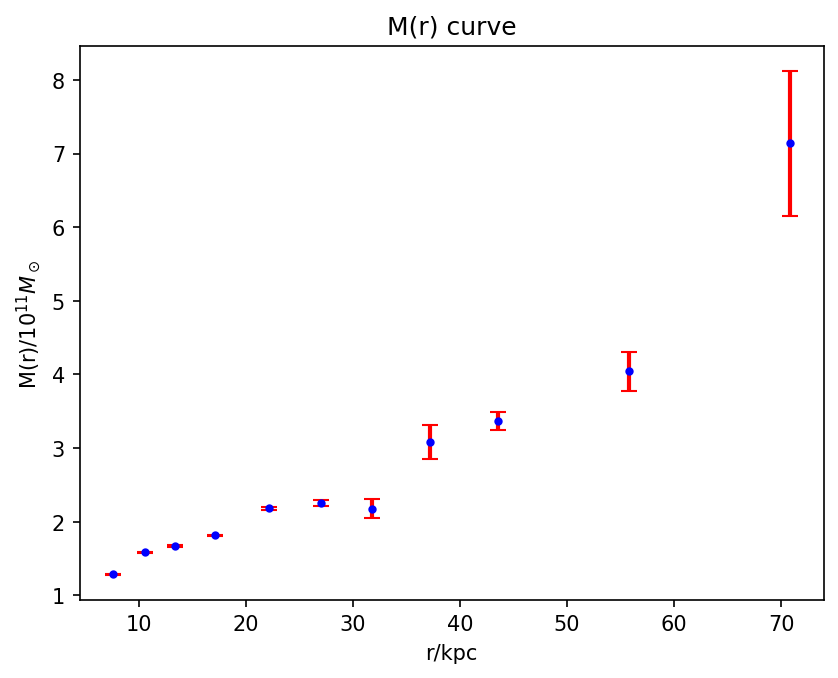

In [23]:
plt.figure(dpi=150)
plt.errorbar(r,mm/1e11,yerr=me/1e11,marker='o', markersize=3,ecolor='r',color='b',elinewidth=2,capsize=4,linestyle='none')
plt.xlabel('r/kpc')
plt.ylabel(r'M(r)/$10^{11}M_\odot$')
plt.title('M(r) curve')
plt.show()

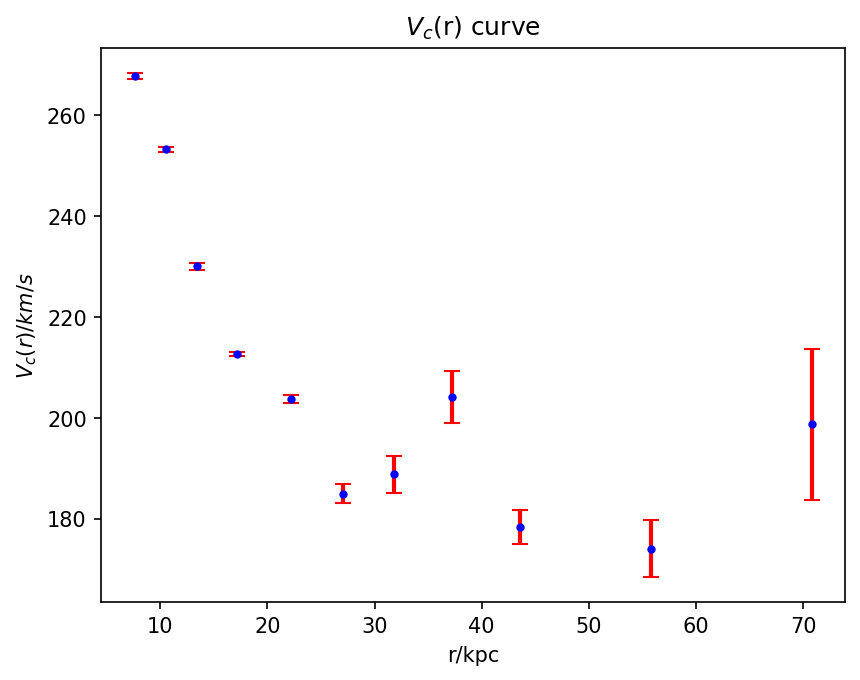

In [25]:
plt.figure(dpi=150)
plt.errorbar(r,vm,yerr=ve,marker='o', markersize=3,ecolor='r',color='b',elinewidth=2,capsize=4,linestyle='none')
plt.xlabel('r/kpc')
plt.ylabel(r'$V_c(r)/km/s$')
plt.title(r'$V_c$(r) curve')
plt.show()

## 3.拟合NFW

In [26]:
def f(x):
    return np.log(1+x)-x/(1+x)

def NFW(r,Mv,c):
    rv=206*np.power(Mv/10,1/3)
    return Mv*f(c*r/rv)/f(c)

In [30]:
p,cov=curve_fit(NFW,r,mm/1e11-0.8,p0=(13,26))
print(p,cov)

[30.28255128  3.00153235] [[300.5452259  -23.58440531]
 [-23.58440531   1.93783164]]


拟合得到 $M_{vir}=3.0\times10^{12}M_\odot,c=3.0$

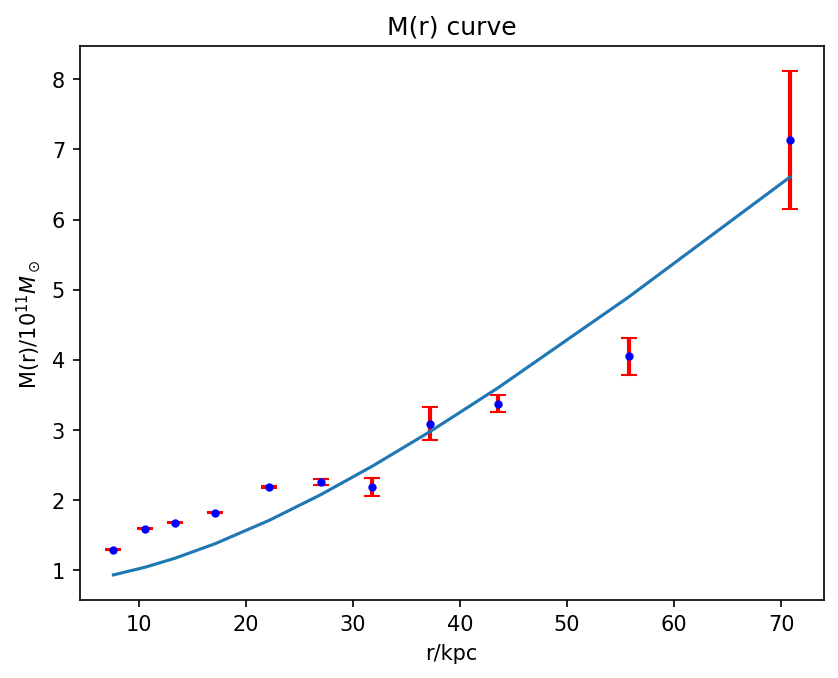

In [29]:
plt.figure(dpi=150)
plt.errorbar(r,mm/1e11,yerr=me/1e11,marker='o', markersize=3,ecolor='r',color='b',elinewidth=2,capsize=4,linestyle='none')
plt.plot(r,NFW(r,p[0],p[1])+0.8)
plt.xlabel('r/kpc')
plt.ylabel(r'M(r)/$10^{11}M_\odot$')
plt.title('M(r) curve')
plt.show()